# Modeling

The modeling phase aims to build and evaluate models that support the business objectives, using the analysis ready dataset produced in the `Data Preparation` phase

In [43]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.10.1


In [44]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

input_dir = "../data/processed/"
pkl_path = os.path.join(input_dir, "prepared_art500k_subset_paintings.pkl")

df = pd.read_pickle(pkl_path)

print(f"DataFrame loaded from {pkl_path}")
print(df.info())

DataFrame loaded from ../data/processed/prepared_art500k_subset_paintings.pkl
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 2000 non-null   int64 
 1   image_path         2000 non-null   object
 2   type_landscape     2000 non-null   bool  
 3   type_mythological  2000 non-null   bool  
 4   type_portrait      2000 non-null   bool  
 5   type_religious     2000 non-null   bool  
dtypes: bool(4), int64(1), object(1)
memory usage: 39.2+ KB
None


## Select modeling technique

### Modeling technique
With the limited dataset, transfer learning will be used first to then add fine-tuning. The GPU can be used with tensorflow/keras. One of the models in [keras.io/api/applications](https://keras.io/api/applications/) will be chosen.

The XCeption model has been selected to make a first iteration due to strong accuracy on ImageNet. Besides this is it also suitable for the local GPU

### Modeling assumptions
**Input shape:**
- All input images must be resized to the target dimensions (299x299, 3 channels)
- Images must be preprocessed with `keras.applications.xception.preprocess_input` before input to the model (scaling to [-1, 1]).

**Labels:**
- The number of output classes matches the unique values of the `TYPE` variable (4)

**Dataset Size:**
- Transfer learning with a pre-trained backbone assumes a moderate or small labeled dataset

**Distribution:**
- Model does not require input features to be normally distributed, but assumes the label distribution is sufficiently balanced for meaningful evaluation.

**Augmentation:**
- To enhance generalization, basic image augmentation (random flip, rotation, etc.) can be applied during training if the model performs poorly [keras.io/guides_transfer_learning](https://keras.io/guides/transfer_learning/)

## Test design
in the data preperation step the label was taken out of the dataframe. Now it needs to be added back

In [45]:
onehot_cols = ['type_landscape', 'type_mythological', 'type_portrait', 'type_religious']

# Convert one-hot to class label
df['label'] = np.argmax(df[onehot_cols].values, axis=1)
index_to_type = {i: col.replace('type_', '') for i, col in enumerate(onehot_cols)}
df['label_name'] = df['label'].map(index_to_type)

In [46]:
df.sample(n=5, random_state=SEED)

,id,image_path,type_landscape,type_mythological,type_portrait,type_religious,label,label_name
1860,10448,../data/toy_dataset/10448.jpg,False,False,False,True,3,religious
353,35713,../data/toy_dataset/35713.jpg,False,False,False,True,3,religious
1333,8843,../data/toy_dataset/8843.jpg,False,True,False,False,1,mythological
905,19304,../data/toy_dataset/19304.jpg,False,False,False,True,3,religious
1289,9110,../data/toy_dataset/9110.jpg,True,False,False,False,0,landscape


Using stratification so all train/validation/test splits have relative proportions of each label. a split of 

In [47]:
# 80/20
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=SEED
)

# 50/50 of the 20%
validation_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=SEED
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(validation_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 1600
Validation samples: 200
Test samples: 200


## Build model

In [48]:
BATCH_SIZE = 32
IMG_SIZE = (299, 299)
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE
ONE_HOT_DIMENSIONS = 4
DROPOUT_RATE = 0.4

Function to parse images on the fly

In [49]:
def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = keras.applications.xception.preprocess_input(image)
    return image, label

Create TensorFlow Datasets from DataFrame slices

In [50]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'].values, train_df['label'].values)
).map(parse_image, num_parallel_calls=AUTOTUNE) \
 .batch(BATCH_SIZE) \
 .prefetch(AUTOTUNE)

validation_ds = tf.data.Dataset.from_tensor_slices(
    (validation_df['image_path'].values, validation_df['label'].values)
).map(parse_image, num_parallel_calls=AUTOTUNE) \
 .batch(BATCH_SIZE) \
 .prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['image_path'].values, test_df['label'].values)
).map(parse_image, num_parallel_calls=AUTOTUNE) \
 .batch(BATCH_SIZE) \
 .prefetch(AUTOTUNE)

Load the XCeption model

In [51]:
keras.backend.clear_session()

base_model = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False

Build model head

In [52]:
inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = keras.layers.Dense(ONE_HOT_DIMENSIONS, activation='softmax')(x)
model = keras.Model(inputs, outputs)

Compile model

In [53]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
_____________________________________________

Train the model

In [54]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
50/50 [==============================] - 17s 300ms/step - loss: 1.0223 - accuracy: 0.5738 - val_loss: 0.6987 - val_accuracy: 0.7650
Epoch 2/10
50/50 [==============================] - 14s 287ms/step - loss: 0.6852 - accuracy: 0.7462 - val_loss: 0.6165 - val_accuracy: 0.7800
Epoch 3/10
50/50 [==============================] - 14s 289ms/step - loss: 0.6095 - accuracy: 0.7675 - val_loss: 0.5944 - val_accuracy: 0.7750
Epoch 4/10
50/50 [==============================] - 15s 296ms/step - loss: 0.5650 - accuracy: 0.7869 - val_loss: 0.5831 - val_accuracy: 0.7700
Epoch 5/10
50/50 [==============================] - 15s 308ms/step - loss: 0.5452 - accuracy: 0.8019 - val_loss: 0.5720 - val_accuracy: 0.7650
Epoch 6/10
50/50 [==============================] - 16s 317ms/step - loss: 0.5248 - accuracy: 0.8150 - val_loss: 0.5702 - val_accuracy: 0.7650
Epoch 7/10
50/50 [==============================] - 17s 336ms/step - loss: 0.4972 - accuracy: 0.8238 - val_loss: 0.5674 - val_accuracy: 0.7650

### Loss plot

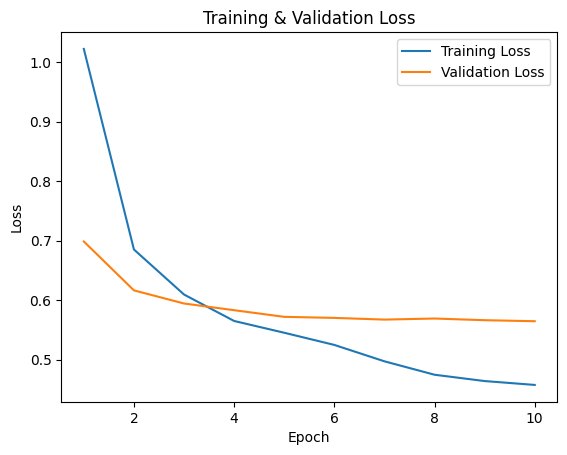

In [55]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Both curves fall steeply in the first 2–3 epochs. This means the learning rate and initial model capacity are sufficient to capture the broad structure quickly. After about epoch 3-4 validation loss flattens just below 0.6 whereas training loss keeps decreasing steadily down to below 0.5 by epoch 10.
This might indicate overfitting. The model continues to fit the training data better but those gains no longer generalize.
The gap between training and validation loss is modest at epoch 3 but grows bigger by epoch 10. This gap could be a sign of overfitting

### Accuracy plot

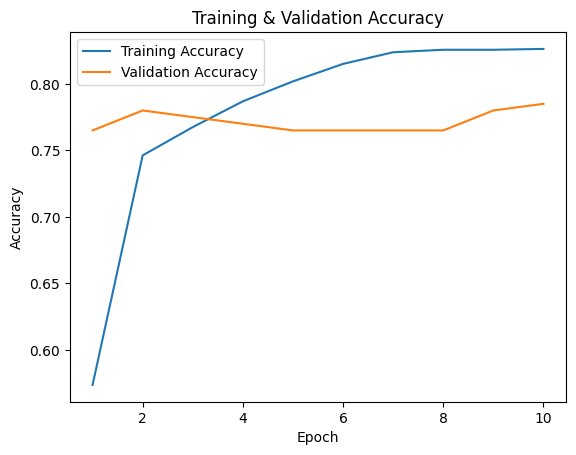

In [56]:
plt.figure()
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Validation accuracy climbs quickly showing the model learns the bulk of generalizable patterns very early. After epoch 3 validation accuracy stagnates and then dips slightly to then raise again by epoch 10. Meanwhile training accuracy continues rising reaching ~0.82 at epoch 10.

The gap between training and validation accuracy grows from almost nothing at epoch 3 to ~0.07 by epoch 10. This could be a sign of overfitting

In [57]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 2s 230ms/step - loss: 0.5746 - accuracy: 0.7850
Test accuracy: 0.785


The accuracy is still quite good for the size of the dataset

## Finetuning
Now the transfer learned model with will finetuned to see if any accuracy gains are possible

In [58]:
# Unfreeze the top N layers for fine-tuning
N_FINE_TUNE_LAYERS = 30
for layer in base_model.layers[-N_FINE_TUNE_LAYERS:]:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
50/50 [==============================] - 19s 306ms/step - loss: 0.4142 - accuracy: 0.8575 - val_loss: 0.5642 - val_accuracy: 0.7900
Epoch 2/10
50/50 [==============================] - 15s 297ms/step - loss: 0.4133 - accuracy: 0.8544 - val_loss: 0.5639 - val_accuracy: 0.7900
Epoch 3/10
50/50 [==============================] - 15s 298ms/step - loss: 0.4025 - accuracy: 0.8631 - val_loss: 0.5637 - val_accuracy: 0.7900
Epoch 4/10
50/50 [==============================] - 15s 297ms/step - loss: 0.4045 - accuracy: 0.8562 - val_loss: 0.5635 - val_accuracy: 0.7950
Epoch 5/10
50/50 [==============================] - 15s 300ms/step - loss: 0.4028 - accuracy: 0.8631 - val_loss: 0.5634 - val_accuracy: 0.7950
Epoch 6/10
50/50 [==============================] - 15s 303ms/step - loss: 0.4106 - accuracy: 0.8587 - val_loss: 0.5632 - val_accuracy: 0.7950
Epoch 7/10
50/50 [==============================] - 15s 301ms/step - loss: 0.4030 - accuracy: 0.8644 - val_loss: 0.5631 - val_accuracy: 0.7950

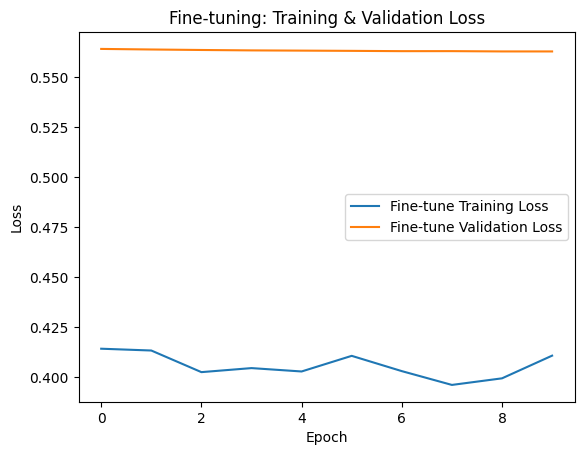

In [59]:
plt.figure()
plt.plot(history_finetune.history['loss'], label='Fine-tune Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Fine-tune Validation Loss')
plt.title('Fine-tuning: Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training loss decreases slightly during finetuning showing that the model continues to improve its fit to the training data, there is a small uptick at epoch 10. The validation loss remains completely flat throughout all epochs. This suggests that the models ability to generalize to unseen validation data does not improve. The static validation loss indicates that finetuning has no measurable impact on model confidence for the validation set.

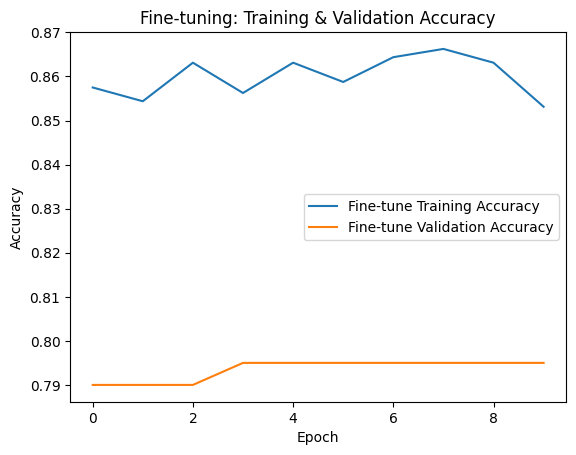

In [60]:
plt.figure()
plt.plot(history_finetune.history['accuracy'], label='Fine-tune Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Fine-tune Validation Accuracy')
plt.title('Fine-tuning: Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Training accuracy shows a small upward trend reflecting modest improvement on the training set up to epoch 4. Validation accuracy increases slightly over the course of finetuning. This indicates that the model is able to correctly classify more validation samples even though its overall prediction confidence as measured by loss does not change. While the gain is limited, this upward movement in validation accuracy confirms some positive impact of finetuning on classification performance.

In [74]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 2s 218ms/step - loss: 0.5718 - accuracy: 0.7950
Test loss: 0.572
Test accuracy: 0.795


## Finetuning second attempt

In a previous iteration data augmentation proved to not be useful for transfer learning with the datasamples used. In this iteration finetuning is added on top of the transfer learned model and with this change data augmentation could be key in creating improvement gains

In [62]:
augmentation_layers = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
], name="data_augmentation")

train_dsB = (
    tf.data.Dataset
    .from_tensor_slices((train_df['image_path'].values, train_df['label'].values))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (augmentation_layers(x, training=True), y),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [63]:
inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = keras.layers.Dense(ONE_HOT_DIMENSIONS, activation='softmax')(x)
modelB = keras.Model(inputs, outputs)

In [64]:
modelB.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

modelB.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
___________________________________________

In [65]:
historyB = modelB.fit(
    train_dsB,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
50/50 [==============================] - 18s 314ms/step - loss: 1.0660 - accuracy: 0.5381 - val_loss: 0.7355 - val_accuracy: 0.7600
Epoch 2/10
50/50 [==============================] - 16s 311ms/step - loss: 0.7452 - accuracy: 0.7025 - val_loss: 0.6635 - val_accuracy: 0.7500
Epoch 3/10
50/50 [==============================] - 18s 367ms/step - loss: 0.6771 - accuracy: 0.7344 - val_loss: 0.6309 - val_accuracy: 0.7650
Epoch 4/10
50/50 [==============================] - 19s 380ms/step - loss: 0.6372 - accuracy: 0.7481 - val_loss: 0.6244 - val_accuracy: 0.7700
Epoch 5/10
50/50 [==============================] - 19s 378ms/step - loss: 0.6341 - accuracy: 0.7487 - val_loss: 0.5982 - val_accuracy: 0.7700
Epoch 6/10
50/50 [==============================] - 19s 372ms/step - loss: 0.6024 - accuracy: 0.7650 - val_loss: 0.6059 - val_accuracy: 0.7650
Epoch 7/10
50/50 [==============================] - 19s 375ms/step - loss: 0.5810 - accuracy: 0.7744 - val_loss: 0.5979 - val_accuracy: 0.7600

In [66]:
for layer in base_model.layers[-N_FINE_TUNE_LAYERS:]:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True

modelB.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history_finetuneB = modelB.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
50/50 [==============================] - 18s 304ms/step - loss: 0.5165 - accuracy: 0.8006 - val_loss: 0.5797 - val_accuracy: 0.7700
Epoch 2/10
50/50 [==============================] - 15s 297ms/step - loss: 0.5188 - accuracy: 0.8062 - val_loss: 0.5753 - val_accuracy: 0.7700
Epoch 3/10
50/50 [==============================] - 15s 298ms/step - loss: 0.5048 - accuracy: 0.8263 - val_loss: 0.5718 - val_accuracy: 0.7650
Epoch 4/10
50/50 [==============================] - 15s 300ms/step - loss: 0.5085 - accuracy: 0.8037 - val_loss: 0.5689 - val_accuracy: 0.7650
Epoch 5/10
50/50 [==============================] - 15s 300ms/step - loss: 0.4977 - accuracy: 0.8131 - val_loss: 0.5667 - val_accuracy: 0.7650
Epoch 6/10
50/50 [==============================] - 15s 301ms/step - loss: 0.4992 - accuracy: 0.8094 - val_loss: 0.5653 - val_accuracy: 0.7650
Epoch 7/10
50/50 [==============================] - 15s 304ms/step - loss: 0.4972 - accuracy: 0.8169 - val_loss: 0.5642 - val_accuracy: 0.7600

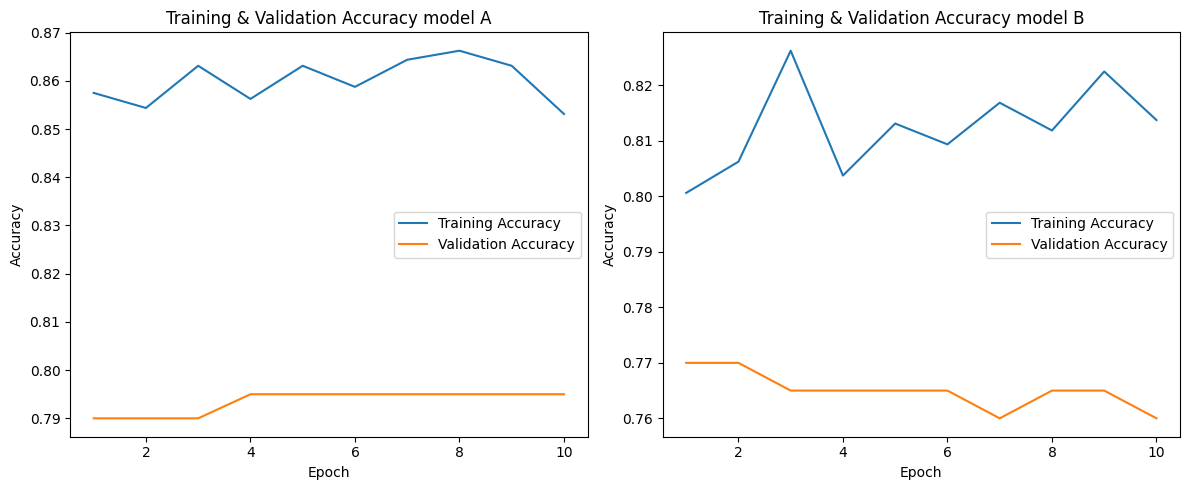

In [70]:
# Same amount of epochs for both models
epochs = range(1, len(history.history['loss']) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Model A
axs[0].plot(epochs, history_finetune.history['accuracy'], label='Training Accuracy')
axs[0].plot(epochs, history_finetune.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Training & Validation Accuracy model A')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Model B
axs[1].plot(epochs, history_finetuneB.history['accuracy'], label='Training Accuracy')
axs[1].plot(epochs, history_finetuneB.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training & Validation Accuracy model B')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Adding augmentation (Model B) made training more challenging and reduced overfitting but did not improve validation accuracy in this experiment. This could be due to overly augmentation decisions or the model needing additional adjustment to benefit from augmentation. Further tuning of the augmentation pipeline and training is a good next step to realize the generalization benefits of data augmentation.

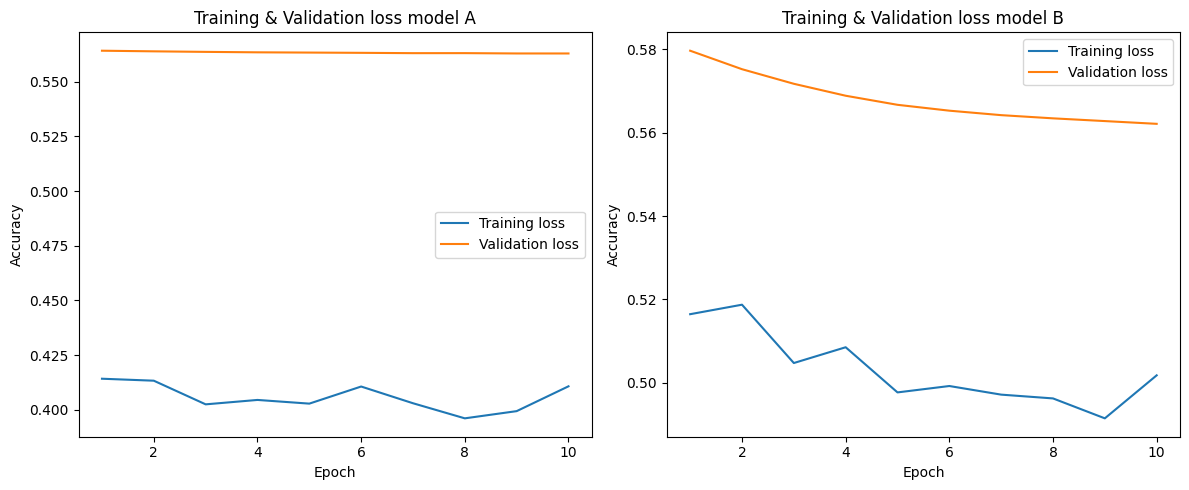

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Model A
axs[0].plot(epochs, history_finetune.history['loss'], label='Training loss')
axs[0].plot(epochs, history_finetune.history['val_loss'], label='Validation loss')
axs[0].set_title('Training & Validation loss model A')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Model B
axs[1].plot(epochs, history_finetuneB.history['loss'], label='Training loss')
axs[1].plot(epochs, history_finetuneB.history['val_loss'], label='Validation loss')
axs[1].set_title('Training & Validation loss model B')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

While data augmentation makes training more challenging and increases training loss it leads to a meaningful decrease in validation loss over time demonstrating improved generalization and reduced overfitting. This is a strong indication that data augmentation is working and good even if short-term accuracy does not immediately increase. Continued tuning and/or longer training may be needed to translate this validation loss improvement into higher validation accuracy

In [67]:
test_loss, test_acc = modelB.evaluate(test_ds)
print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 2s 238ms/step - loss: 0.6002 - accuracy: 0.7600
Test loss: 0.600
Test accuracy: 0.760


# Asses Model
In this modelling phase two fine-tuned models were evaluated on an expanded dataset using the Xception backbone. Model A was fine-tuned without data augmentation, while Model B incorporated data augmentation (random horizontal flips, rotations, and zooms).


**Previous iterations best model (iteration 0, model C)**
- base model: Xception
- Training samples: 640
- Validation samples: 80
- Test samples: 80
- DROPOUT_RATE = 0.4
- BATCH_SIZE = 32
- IMG_SIZE = (299, 299)
- AUTOTUNE = tf.data.AUTOTUNE
- ONE_HOT_DIMENSIONS = 4
- EPOCHS = 10

- accuracy on test set: 0.800
- model fit time: 1m 8.4s


**General value for all models this iteration**
- base model: Xception
- Training samples: 1600
- Validation samples: 200
- Test samples: 200
- BATCH_SIZE = 32
- DROPOUT_RATE = 0.4
- IMG_SIZE = (299, 299)
- EPOCHS = 10
- AUTOTUNE = tf.data.AUTOTUNE
- ONE_HOT_DIMENSIONS = 4


**Finetuned modelA**
- loss on test set: 0.572
- accuracy on test set: 0.795
- model fit time: 5 min 2 seconds

**Finetuned modelB**
- Added data augmentation (horizontalflip, rotation, zoom)
- loss on test set: 0.600
- accuracy on test set: 0.760
- model fit time: 5 min 33 seconds



## Conclusion
Despite Model Bs improved validation loss trend during training, indicating potential for better generalization, the benefit did not translate to the test set. In fact Model B performed worse in both accuracy and loss compared to Model A. The likely reasons are that the augmentations may have been too aggressive for the available data or not well-matched to the task or the dataset size remains a limiting factor.

It is likely that all images in the current dataset are taken under standardized and ideal conditions. As a result data augmentation may have introduced variations not present in the test set which could explain Model Bs lower performance. However if the model is ever used on less controlled or user uploaded images augmentation could help improve robustness.

The training and validation curves support this conclusion. Model A maintained higher accuracy, while Model B though less prone to overfitting failed to close the generalization gap or improve real-world performance.

Therefore Model A is selected as the better model for this iteration as it delivers the highest test accuracy and lowest test loss, and thus the strongest real world performance with the current setup.

Going forward further performance gains may be possible by:
- Carefully tuning augmentation parameters
- Running longer training schedules
- Leveraging other regularization techniques such as label smoothing.

With the present results fine-tuning without augmentation remains the most effective approach for this dataset and problem

## Save for evaluation
Saving the model will not be performed as previous model has not been beaten